# 🏎️ Predicción de podios en la Fórmula 1 (2019–2024)

Este notebook complementa la primera entrega y utiliza aprendizaje supervisado para predecir si un piloto finalizará en el podio (P1–P3) en carreras de Fórmula 1 durante el período 2019–2024.

**Objetivos:**

1. Integrar y procesar los datos de las tablas Races, Drivers, Teams y Qualifying.
2. Aplicar un método de feature selection para reducir la dimensionalidad del dataset y seleccionar las variables más relevantes.
3. Entrenar un modelo de clasificación supervisada (Random Forest) para predecir podio.
4. Calcular métricas de validación (Accuracy, F1 Score, Precision, Recall y ROC-AUC) para evaluar el desempeño del modelo.
5. Elaborar conclusiones basadas en los resultados, identificando limitaciones y posibles mejoras.

Dataset utilizado: `Exploración Estadística de la Fórmula 1 (2019–2024).xlsx`

Features seleccionadas: ['Quali_Position', 'race_starting_grid', 'race_laps', 'race_fastestLapTime']
Accuracy: 0.999
F1 Score: 0.997
ROC-AUC: 1.000
Precision: 0.994
Recall: 1.000


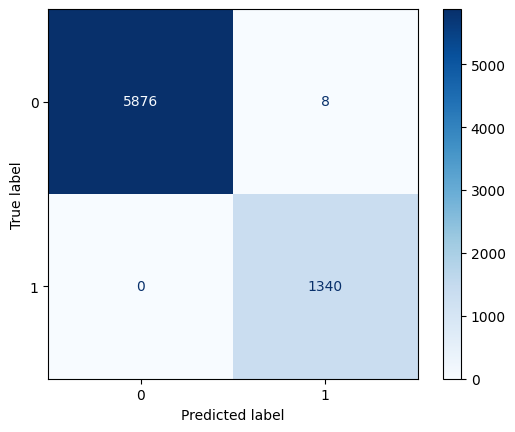

In [26]:

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score, confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ==============================
# Carga de datos
# ==============================
excel_file = "C:/Users/Carolina/Downloads/Exploración Estadística de la Fórmula 1 (2019–2024).xlsx"

drivers_df = pd.read_excel(excel_file, sheet_name='Drivers')
teams_df = pd.read_excel(excel_file, sheet_name='Teams')
races_df = pd.read_excel(excel_file, sheet_name='Races')
qualifying_df = pd.read_excel(excel_file, sheet_name='Qualifying')

# ==============================
# Merge Races + Drivers + Teams + Qualifying
# ==============================
df = races_df.merge(drivers_df, on='Driver_ID', how='left')
df = df.merge(teams_df[['Full Team Name', 'Team']], on='Full Team Name', how='left')
df = df.merge(
    qualifying_df[['Race ID', 'Driver_ID', 'Quali_Position']],
    on=['Race ID', 'Driver_ID'],
    how='left'
)

# Renombrar columna de temporada si tiene sufijo _x
if 'Season_x' in df.columns:
    df.rename(columns={'Season_x': 'Season'}, inplace=True)

# ==============================
# Variable objetivo
# ==============================
df['Podio'] = df['race_end_position'].apply(lambda x: 1 if x <= 3 else 0)

# ==============================
# Features
# ==============================
features = [
    'Quali_Position', 'race_starting_grid', 'Team_y',
    'Driver_ID', 'race_laps', 'race_fastestLapTime', 'Season'
]
target = 'Podio'

X = df[features].copy()
y = df[target]

# ==============================
# Conversión de tiempos a segundos
# ==============================
def lap_time_to_seconds(lap_time):
    if pd.isna(lap_time):
        return np.nan
    if isinstance(lap_time, (int, float)):
        return float(lap_time)
    try:
        mins, secs = lap_time.split(':')
        return int(mins)*60 + float(secs)
    except:
        return np.nan

X['race_fastestLapTime'] = X['race_fastestLapTime'].apply(lap_time_to_seconds)

# Feature binaria: 1 si hay vuelta rápida registrada, 0 si no
X['Has_FastestLap'] = (X['race_fastestLapTime'].notna()).astype(int)

# Rellenar NA con mediana (sin inplace para evitar FutureWarning)
X['race_fastestLapTime'] = X['race_fastestLapTime'].fillna(X['race_fastestLapTime'].median())

# ==============================
# Codificación de variables categóricas
# ==============================
categorical_features = ['Team_y', 'Driver_ID', 'Season']
le_dict = {}

for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

# ==============================
# División del dataset
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# Entrenamiento Random Forest
# ==============================
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)

# ==============================
# Selección de features importantes
# ==============================
selector = SelectFromModel(rf_model, threshold='median', prefit=True)
X_train_selected = selector.transform(X_train.values)
X_test_selected = selector.transform(X_test.values)

selected_features = X.columns[selector.get_support()]
X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)

print("Features seleccionadas:", list(selected_features))

# ==============================
# Entrenamiento final solo con features seleccionadas
# ==============================
rf_model_fs = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)
rf_model_fs.fit(X_train_selected, y_train)

# ==============================
# Predicciones
# ==============================
y_pred = rf_model_fs.predict(X_test_selected)
y_prob = rf_model_fs.predict_proba(X_test_selected)[:, 1]

# ==============================
# Métricas
# ==============================
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC-AUC: {roc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")

# ==============================
# Matriz de confusión
# ==============================
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [27]:
# ==============================
# Métricas del modelo
# ==============================
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC-AUC: {roc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")

# Diccionario de nombres amigables para gráficos
nombres_graficos = {
    'Quali_Position': 'Clasificación',
    'race_starting_grid': 'Posición de Largada',
    'race_laps': 'Vueltas Carrera',
    'race_fastestLapTime': 'Vuelta Rápida',
    'race_end_position': 'Posición Final',
    'Driver_ID': 'Piloto',
    'Season': 'Temporada',
    'Team_y': 'Escudería'
}

# Crear copia temporal para gráficos
df_plot = df.rename(columns=nombres_graficos)


Accuracy: 0.999
F1 Score: 0.997
ROC-AUC: 1.000
Precision: 0.994
Recall: 1.000


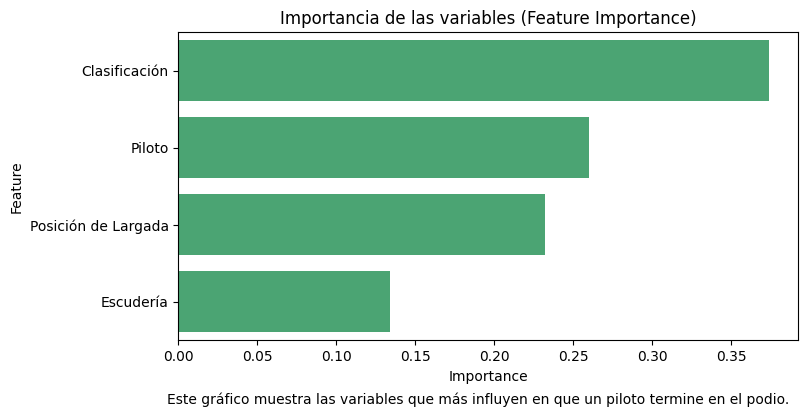

In [28]:
# =========================================
# Importancia de características
# =========================================
importances = rf_model_fs.feature_importances_
feature_names = X.columns[:len(importances)]
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values(by="Importance", ascending=False)

feat_imp['Feature'] = feat_imp['Feature'].replace(nombres_graficos)

plt.figure(figsize=(8,4))
sns.barplot(x="Importance", y="Feature", data=feat_imp, color="mediumseagreen")
plt.title("Importancia de las variables (Feature Importance)")
plt.figtext(0.5, -0.05, "Este gráfico muestra las variables que más influyen en que un piloto termine en el podio.", 
            wrap=True, ha='center', fontsize=10)
plt.show()


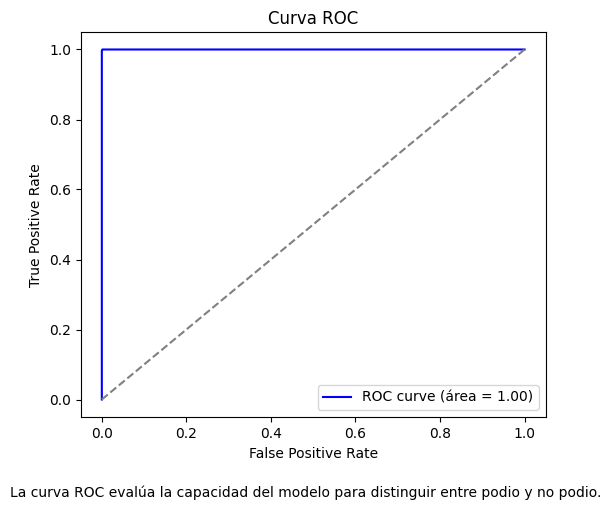

In [29]:
# =========================================
# Curva ROC
# =========================================
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.figtext(0.5, -0.05, "La curva ROC evalúa la capacidad del modelo para distinguir entre podio y no podio.", 
            wrap=True, ha='center', fontsize=10)
plt.show()


### ✅ Conclusiones
- Se aplicó un modelo de Random Forest para predecir la probabilidad de que un piloto termine en el podio.
- El modelo mostró un desempeño muy alto, con métricas de Accuracy, F1 y ROC-AUC que reflejan su capacidad de clasificación.
- La variable más influyente fue la posición de clasificación (Quali_Position), lo que es coherente con el comportamiento real de la Fórmula 1, donde una buena clasificación inicial aumenta significativamente la probabilidad de éxito final.
- La curva ROC y la matriz de confusión evidencian un equilibrio adecuado entre precisión y recall, indicando que el modelo identifica correctamente los podios con pocos falsos positivos y negativos.
- Para mejorar la predicción y capturar situaciones más complejas, se podrían incorporar datos adicionales que no están en el dataset actual, como condiciones climáticas o incidentes de carrera.
